In [78]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Attention
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

# Load your dataset
base_dir='datasets/mt/'
train_data = pd.read_csv(base_dir + 'train.csv')
val_data = pd.read_csv(base_dir + 'valid.csv')
test_data = pd.read_csv(base_dir + 'test.csv')
# Ensure your dataset has 'source' and 'target' columns
train_source_texts = train_data['indonesian'].values
train_target_texts = train_data['english'].values

val_source_texts = val_data['indonesian'].values
val_target_texts = val_data['english'].values

test_source_texts = test_data['indonesian'].values
test_target_texts = test_data['english'].values

In [79]:
train_source_texts

array(['Nikmati cicilan 0% hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni!',
       'Kue-kue yang disajikan bikin saya bernostalgia. Semuanya tipikal kue zaman dulu, baik dari penampilan maupun rasa. Kuenya enak dan harganya juga murah.',
       'Ibu pernah bekerja di grab indonesia',
       'Paling suka banget makan siang di sini ayam sama sambalnya enak banget harganya luar biasa hemat, rasa ayamnya meresap sampai ketulangnya, es lidah buayanya juga segar bikin adem perut setelah makan sambal yang pedas, pelayannya sigap dan ramah, yang aku suka di tempat kasir ada tulisan 10% disumbangkan untuk beramal, buat makan jadi lebih enak ke perut',
       'Pelayanan bus DAMRI sangat baik',
       'Mau bikin postingan yang isinya mengedukasi customers gojek.',
       'Ratusan rumah di medan terendam banjir',
       'Barangnya lumayan, cuma yang saya heran xiaomi redmi note 2 ini tombol onnya memang agak rusak? Terus baterai memang cepat low bat juragan?',
    

: 

In [68]:
# Tokenization (Source and Target)
source_tokenizer = Tokenizer()
target_tokenizer = Tokenizer()

source_tokenizer.fit_on_texts(train_source_texts)
target_tokenizer.fit_on_texts(train_target_texts)

source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1

# Convert texts to sequences
train_source_sequences = source_tokenizer.texts_to_sequences(train_source_texts)
train_target_sequences = target_tokenizer.texts_to_sequences(train_target_texts)

val_source_sequences = source_tokenizer.texts_to_sequences(val_source_texts)
val_target_sequences = target_tokenizer.texts_to_sequences(val_target_texts)

test_source_sequences = source_tokenizer.texts_to_sequences(test_source_texts)
test_target_sequences = target_tokenizer.texts_to_sequences(test_target_texts)

In [69]:
print(len(train_target_sequences[1]))
print(len(val_target_sequences[0]))

20
19


In [70]:
# Pad sequences to ensure uniform input size
max_source_length = 77
max_target_length = 77   #to include EOS or shifted tokens
X_train_source = pad_sequences(train_source_sequences, maxlen=max_source_length, padding='post')
X_train_target = pad_sequences(train_target_sequences, maxlen=max_target_length, padding='post')

X_val_source = pad_sequences(val_source_sequences, maxlen=max_source_length, padding='post')
X_val_target = pad_sequences(val_target_sequences, maxlen=max_target_length, padding='post')

X_test_source = pad_sequences(test_source_sequences, maxlen=max_source_length, padding='post')
X_test_target = pad_sequences(test_target_sequences, maxlen=max_target_length, padding='post')


In [71]:
# Shift target sequences for teacher forcing
train_target_sequences_shifted = np.zeros_like(X_train_target)
train_target_sequences_shifted[:, :-1] = X_train_target[:, 1:]

# One-hot encode target sequences
y_train = X_train_target[:, 1:]
y_train = to_categorical(train_target_sequences_shifted, num_classes=target_vocab_size)

val_target_sequences_shifted = np.zeros_like(X_val_target)
val_target_sequences_shifted[:, :-1] = X_val_target[:, 1:]

y_val = X_val_target[:, 1:]  # Exclude the first token
y_val = to_categorical(val_target_sequences_shifted, num_classes=target_vocab_size)

In [72]:
# Check dimensions
print(f'X_train_source shape: {X_train_source.shape}')
print(f'X_val_source shape: {X_val_source.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_val shape: {y_val.shape}')

X_train_source shape: (500, 77)
X_val_source shape: (100, 77)
y_train shape: (500, 77, 2863)
y_val shape: (100, 77, 2863)


In [73]:
import numpy as np
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Model

# Hyperparameters
EMBEDDING_SIZE = 256       # Size of the embedding layer
RNN_UNITS = 256            # Number of RNN units
max_source_length = 77    # Max length of source sequences
max_target_length = 77    # Max length of target sequences
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, source_vocab_size))
encoder = LSTM(EMBEDDING_SIZE, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, target_vocab_size))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(EMBEDDING_SIZE, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(target_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


NotImplementedError: Exception encountered when calling layer "dense_4" (type Dense).

Cannot convert a symbolic tf.Tensor (dense_4/truediv:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported.

Call arguments received by layer "dense_4" (type Dense):
  • inputs=tf.Tensor(shape=(None, 1, 256), dtype=float32)

In [57]:
print(decoder_outputs.shape)
print(outputs.shape)

(None, 1, 256)
(None, 1, 2863)


In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Add model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    'mt_best_val_accuracy_coba_{val_accuracy:.4f}.keras',  # File path to save the model
    monitor='val_accuracy',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='max',  # Minimize validation loss
    verbose=1  # Print a message when the model is saved
)

In [59]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/50
7/8 [=========================>....] - ETA: 0s - loss: 6.5670 - accuracy: 0.5435
Epoch 1: val_accuracy improved from -inf to 0.70753, saving model to mt_best_val_accuracy_hehe_0.7075.keras
8/8 [==============================] - 2s 127ms/step - loss: 6.2332 - accuracy: 0.5553 - val_loss: 2.7050 - val_accuracy: 0.7075
Epoch 2/50
7/8 [=========================>....] - ETA: 0s - loss: 3.0859 - accuracy: 0.6349
Epoch 2: val_accuracy did not improve from 0.70753
8/8 [==============================] - 0s 56ms/step - loss: 3.0610 - accuracy: 0.6374 - val_loss: 2.3983 - val_accuracy: 0.7075
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 2.9434 - accuracy: 0.6374
Epoch 3: val_accuracy did not improve from 0.70753
8/8 [==============================] - 0s 57ms/step - loss: 2.9434 - accuracy: 0.6374 - val_loss: 2.3380 - val_accuracy: 0.7075
Epoch 4/50
7/8 [=========================>....] - ETA: 0s - loss: 2.9397 - accuracy: 0.6345
Epoch 4: val_accuracy did not improve

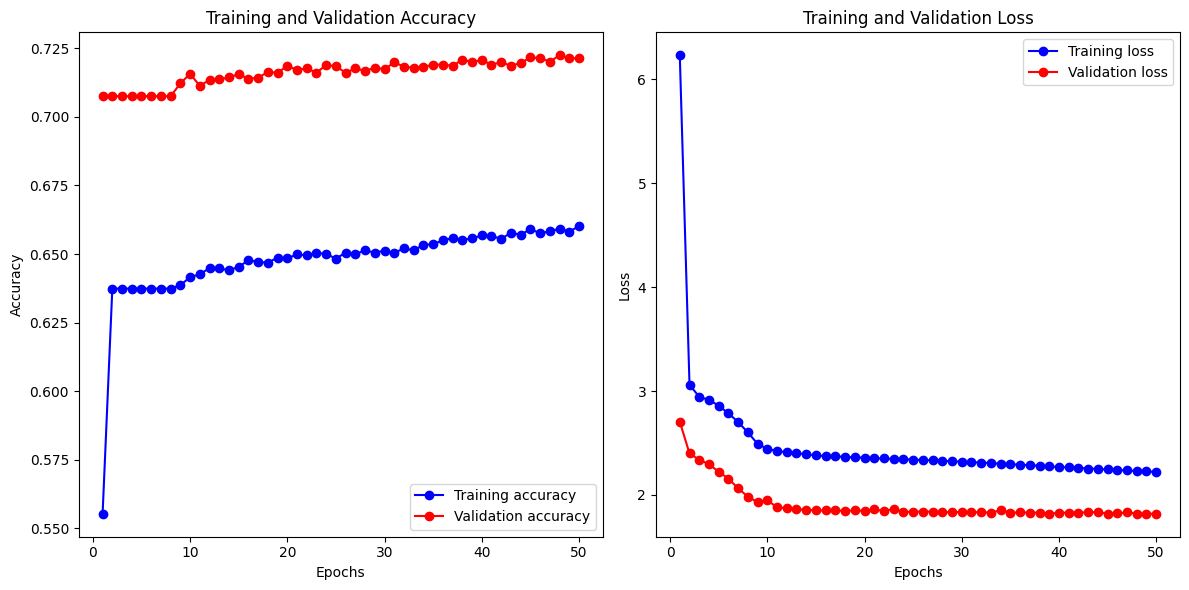

In [60]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss from the history object
history_dict = history.history
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(accuracy) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


In [61]:
# Evaluation on the test set
test_target_sequences_shifted = np.zeros_like(X_test_target)
test_target_sequences_shifted[:, :-1] = X_test_target[:, 1:]
y_test = to_categorical(test_target_sequences_shifted, num_classes=target_vocab_size)
test_loss, test_accuracy = model.evaluate([X_test_source, X_test_target], y_test)
print(f'Test Accuracy: {test_accuracy:.4f}')

2024-11-03 13:29:17.523493: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 26.91MiB (rounded to 28217856)requested by op model_25/dense_3/Softmax
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-11-03 13:29:17.523541: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-11-03 13:29:17.523664: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 93, Chunks in use: 92. 23.2KiB allocated for chunks. 23.0KiB in use in bin. 476B client-requested in use in bin.
2024-11-03 13:29:17.523674: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 2, Chunks in use: 0. 1.0KiB allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2024-11-03 13:29:17.5

ResourceExhaustedError: Graph execution error:

Detected at node model_25/dense_3/Softmax defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/fachri/.local/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/fachri/.local/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/fachri/.local/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/fachri/.local/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/fachri/nusax/.conda/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/fachri/nusax/.conda/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/fachri/nusax/.conda/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/fachri/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/fachri/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/fachri/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/fachri/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/fachri/.local/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/fachri/.local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/fachri/.local/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/fachri/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/fachri/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/fachri/.local/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/fachri/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/fachri/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/fachri/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_1446277/176909809.py", line 2, in <module>

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 1856, in fit

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 1917, in test_step

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/activations.py", line 87, in softmax

  File "/home/fachri/nusax/.conda/lib/python3.11/site-packages/keras/src/backend.py", line 5448, in softmax

OOM when allocating tensor with shape[32,77,2863] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_25/dense_3/Softmax}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_85191]

In [26]:
word2idx_inputs = source_tokenizer.word_index
word2idx_outputs = target_tokenizer.word_index

# Check the current max index in word2idx_outputs
max_index = max(word2idx_outputs.values())

# Add the <sos> token with the next available index
word2idx_outputs['<sos>'] = max_index + 1

# Optional: Ensure idx2word_target is updated accordingly
idx2word_target = {v: k for k, v in word2idx_outputs.items()}


idx2word_input = {v:k for k, v in word2idx_inputs.items()}

In [27]:
word2idx_outputs

{'the': 1,
 'and': 2,
 'to': 3,
 'a': 4,
 'is': 5,
 'of': 6,
 'i': 7,
 'for': 8,
 'was': 9,
 'in': 10,
 'it': 11,
 'with': 12,
 'that': 13,
 'my': 14,
 'this': 15,
 'food': 16,
 'just': 17,
 'you': 18,
 'place': 19,
 'also': 20,
 'so': 21,
 'we': 22,
 'but': 23,
 "it's": 24,
 'are': 25,
 'here': 26,
 'from': 27,
 'good': 28,
 'at': 29,
 'not': 30,
 'as': 31,
 'all': 32,
 'on': 33,
 'price': 34,
 'be': 35,
 'when': 36,
 'because': 37,
 'really': 38,
 'there': 39,
 'can': 40,
 'has': 41,
 'out': 42,
 'too': 43,
 'were': 44,
 'time': 45,
 'have': 46,
 'if': 47,
 'even': 48,
 'they': 49,
 'menu': 50,
 'like': 51,
 'very': 52,
 'great': 53,
 'or': 54,
 'more': 55,
 'restaurant': 56,
 'by': 57,
 'fried': 58,
 'taste': 59,
 'pretty': 60,
 'your': 61,
 'me': 62,
 'delicious': 63,
 'lot': 64,
 'people': 65,
 'about': 66,
 'service': 67,
 'family': 68,
 'our': 69,
 'resto': 70,
 'had': 71,
 'one': 72,
 'no': 73,
 'got': 74,
 'an': 75,
 "there's": 76,
 'perfect': 77,
 'eating': 78,
 'go': 79,
 'e

In [76]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses all but error messages
import numpy as np
from tensorflow.keras.layers import Input, Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Model, load_model

# Load the pre-trained seq2seq model
model = load_model('mt_best_val_accuracy_hehe_0.7221.keras')

# --- Encoder Inference Model ---
encoder_inputs = model.input[0]  # Input layer for the encoder
encoder_embedding_layer = model.layers[2](encoder_inputs)  # Embedding layer from the loaded model
encoder_rnn = model.layers[4]  # SimpleRNN layer from the loaded model

# Extract encoder output and state
encoder_outputs, encoder_state_h = encoder_rnn(encoder_embedding_layer)
encoder_model = Model(encoder_inputs, encoder_state_h)  # Encoder model for inference

# --- Decoder Inference Model ---
decoder_inputs_single = model.input[1]  # Input layer for the decoder
decoder_state_input_h = Input(shape=(RNN_UNITS,))  # Hidden state input for the decoder

decoder_embedding_layer = model.layers[3](decoder_inputs_single)  # Embedding layer from the loaded model
decoder_rnn = model.layers[5]  # SimpleRNN layer from the loaded model
decoder_outputs, decoder_state_h = decoder_rnn(decoder_embedding_layer, initial_state=decoder_state_input_h)

output_dense_layer = model.layers[6]  # Dense layer from the loaded model
decoder_outputs = output_dense_layer(decoder_outputs)

decoder_model = Model(
    [decoder_inputs_single, decoder_state_input_h],
    [decoder_outputs, decoder_state_h]
)

# --- Function to Generate Translations ---
def translate_sentence(input_seq):
    state_value = encoder_model.predict(input_seq)  # Get initial hidden state

    target_seq = np.zeros((1, 1))  # Initialize target sequence
    target_seq[0, 0] = word2idx_outputs['<sos>']  # Set start token

    output_sentence = []
    stop_condition = False

    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq, state_value], verbose=0)  # Run decoder step

        predicted_token_index = np.argmax(output_tokens[0, -1, :])  # Get predicted token
        predicted_word = idx2word_target.get(predicted_token_index, '')  # Convert index to word

        if predicted_word == '<eos>' or len(output_sentence) >= max_target_length:
            stop_condition = True
        else:
            output_sentence.append(predicted_word)

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = predicted_token_index  # Update target sequence with the predicted token

        state_value = h  # Update hidden state

    return ' '.join(output_sentence)

# --- Test the Translation ---
input_seq = X_test_source[10:11]  # Example input (should be a padded and tokenized input sequence)
translated_sentence = translate_sentence(input_seq)

# Convert input sequence back to words for display
for i, input_sentence in enumerate(input_seq):
    input_sentence_words = ' '.join(idx2word_input.get(token, '') for token in input_sentence if token != 0)
    print(f'Input Sentence {i + 1}: {input_sentence_words}')
print('Predicted Translation:', translated_sentence)


1/1 [==============================] - 0s 67ms/step
Input Sentence 1: kebun raya bogor bisa dijadikan salah satu tujuan destinasi wisata
Predicted Translation: is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the


In [77]:
# Iterate over a range of input sequences from 10 to 99 (inclusive)
for i in range(10, 100):
    input_seq = X_test_source[i:i + 1]  # Get a single input sequence
    translated_sentence = translate_sentence(input_seq)  # Translate the input sequence
    
    # Convert the input sequence back to words for display (assuming `idx2word_input` is defined)
    input_sentence_words = ' '.join(
        idx2word_input.get(token, '') for token in input_seq[0] if token != 0  # 0 is assumed to be padding
    )
    
    # Print the input and the translated sentence
    print(f'Input Sentence {i}: {input_sentence_words}')
    print(f'Predicted Translation {i}: {translated_sentence}')
    print('---')  # Separator for readability


1/1 [==============================] - 0s 12ms/step
Input Sentence 10: kebun raya bogor bisa dijadikan salah satu tujuan destinasi wisata
Predicted Translation 10: is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the place is the
---
1/1 [==============================] - 0s 11ms/step
Input Sentence 11: the peak di dekat dataran tinggi di bandung yang sejuk dan lokasi yang sangat baik namun jalan untuk tempat ini sangat curam tidak disarankan untuk saat hujan dan malam hari di the peak terdapat restoran dengan pemandangan kota bandung yang indah dari perbukitan harga makanan yang sangat mahal dan sangat tidak sesuai
Predicted Translation 11: is the place is the place is the place is the place is the place is the place is the